In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import database_credentials as dc

In [2]:
# Database credentials
postgres_user = dc.user()
postgres_pw = dc.pw()
postgres_host = dc.host()
postgres_port = dc.port()
postgres_db = dc.db()

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

In [3]:
# Creating a table with all accepted offers in the last 28 days
sql = '''
SELECT carrier_name, carrier_type, status, carrier_guid, order_id, date(accepted_date) 
FROM stms_db2_shipper.offers
WHERE status IN ('paid', 'delivered', 'accepted', 'picked_up', 'invoiced')
AND accepted_date >= date(current_date - interval '28 days')
AND accepted_date < date(current_date)
'''
offers = pd.read_sql_query(sql, con=engine)
offers = offers.rename(columns={'date': 'accepted_date'})
offers

,carrier_name,carrier_type,status,carrier_guid,order_id,accepted_date
0,AMG FREIGHT,CTMS,paid,5b2bdd7b-37ef-420e-bb30-83ea62aa34a8,1063293,2020-12-24
1,SAFE-T-DRIVE TRUCKING LLC,CTMS,invoiced,3be92155-ea52-40b4-aef3-0521d381cbf3,1073116,2020-12-22
2,Robert Dean Transport LLC,CTMS,invoiced,85938415-9959-48b8-9675-86c5e3131ec2,1074865,2020-12-22
3,Suffy Transport,CTMS,paid,cdb6346e-1ba1-42a8-a9c3-e7bf2fb9a5d6,1073895,2020-12-22
4,ABSOLUTE CHAUFFEURED TRANSPORTATION LLC,CTMS,paid,04a69a7b-e8fc-495d-b91f-c66a2cfe86d8,1065954,2020-12-22
...,...,...,...,...,...,...
30091,WINDY TRANS LOGISTICS INC,CTMS,accepted,7e5a3d66-3400-43d5-9a7f-aa65ac56714d,1106452,2021-01-18
30092,D&W Trucking LLC,CTMS,accepted,ec13a230-75f0-46f2-a23d-552df378c648,1110091,2021-01-18
30093,DALE ADAMS,CTMS,accepted,f3f9e7cf-0799-4ab4-8f46-1488cc6ea037,1102588,2021-01-18
30094,JESUS ELIZONDO,CTMS,accepted,b727c45e-01a9-495f-9e4b-3b9a078e9568,1109220,2021-01-18


In [4]:
# Checking for missing values in every column
missing_values = offers.isna().sum()
missing_values

carrier_name     0
carrier_type     0
status           0
carrier_guid     3
order_id         0
accepted_date    0
dtype: int64

In [5]:
# Grouping the offers table to get the unique number of days a carrier accpeted an offer in last 28 days
result = offers.groupby(['carrier_name', 'carrier_guid'])[['accepted_date']].nunique()
result.reset_index(inplace=True)
result = result.rename(columns={'accepted_date': 'unique_days_accepting_offers'})
result

,carrier_name,carrier_guid,unique_days_accepting_offers
0,1 CALL AWAY,d8eeb04e-1f61-4855-9d8c-9fe364dc8044,8
1,1 DAY AUTO TRANSPORT LLC,e7099505-fd84-4b33-b516-619c3dba082b,1
2,10 WEST TRANSPORT LLC,8c18182c-23f2-4179-b65f-3cbd3ac27923,2
3,1ST CHOICE TRANSPORT,9cce6727-adef-40e3-95d7-0b5bfe237ec9,1
4,1ST SHOT TRUCKING LLC,fe1298ef-eb41-4557-a1ef-b266e557ac84,2
...,...,...,...
2975,eco transport,17e62317-e67d-4394-97cb-fcb319d471c3,1
2976,mj parker,13de9609-5f96-43cd-a15e-0765a91613ad,1
2977,peker transportation,8a82a6e7-f15b-4b74-8f23-a09f09d8c93d,1
2978,ref ref,81cc99a5-083b-4346-a369-71ef0efa5e2f,2


In [6]:
result[result['carrier_guid'] == '480ca9b6-9103-44ef-89d6-390accbbd573']

,carrier_name,carrier_guid,unique_days_accepting_offers
590,CAROLINA LOGISTICS INC,480ca9b6-9103-44ef-89d6-390accbbd573,11
591,CAROLINA LOGISTICS INC.,480ca9b6-9103-44ef-89d6-390accbbd573,2
2480,SNOWBIRDS,480ca9b6-9103-44ef-89d6-390accbbd573,1


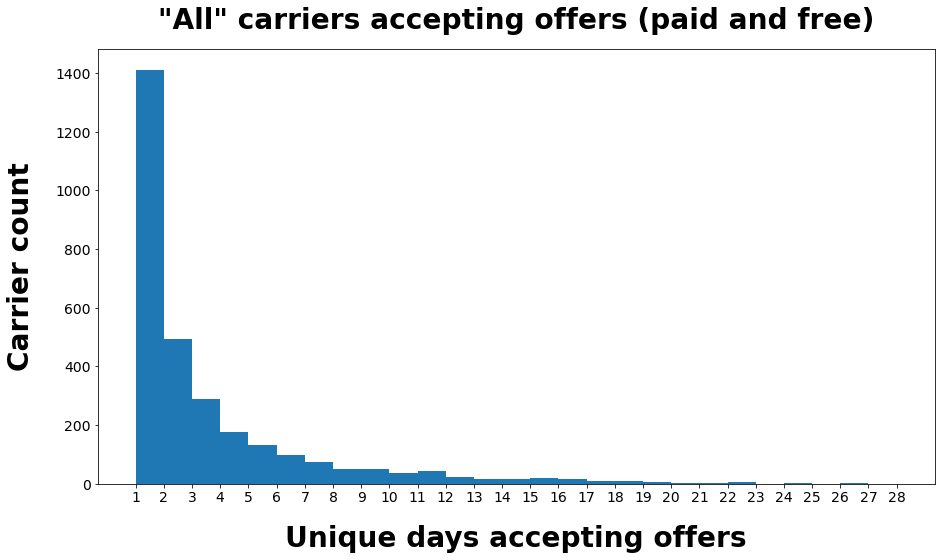

In [7]:
# histogram of unique accepted offers in last 28 days (paid and free users)
plt.figure(figsize=(15,8))
plt.hist(result['unique_days_accepting_offers'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Unique days accepting offers', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Carrier count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('"All" carriers accepting offers (paid and free)', fontsize=28, fontweight='bold', pad=20)
plt.show()

# Now let's segment paid users and free users

In [8]:
# creating a table for braintree subscriptions
sql = '''
DROP TABLE IF EXISTS #carrier_with_latest_sub_date
;
SELECT 
carrier_id
,max(created_at) AS last_sub
INTO #carrier_with_latest_sub_date
FROM ctms_db_public.billing_braintreesubscription
WHERE braintree_subscription_status IN ('Active', 'Past Due', 'Pending')
GROUP BY carrier_id
;
SELECT 
#carrier_with_latest_sub_date.carrier_id
,last_sub
,braintree_subscription_status
FROM #carrier_with_latest_sub_date
JOIN ctms_db_public.billing_braintreesubscription
ON #carrier_with_latest_sub_date.carrier_id = billing_braintreesubscription.carrier_id
AND #carrier_with_latest_sub_date.last_sub = billing_braintreesubscription.created_at
WHERE billing_braintreesubscription.braintree_subscription_status IN ('Active', 'Past Due', 'Pending')
;
'''
braintree_subs = pd.read_sql_query(sql, con=engine)
braintree_subs

,carrier_id,last_sub,braintree_subscription_status
0,5466,2016-11-26 09:21:35.868856,Active
1,3298,2016-11-26 09:21:30.983747,Active
2,4925,2017-01-20 15:19:46.097090,Active
3,1421,2017-05-18 13:42:02.182933,Active
4,433,2017-06-19 19:32:44.584252,Active
...,...,...,...
2866,26442,2021-01-18 18:44:02.175590,Active
2867,40915,2021-01-18 20:07:54.276443,Active
2868,7241,2021-01-18 20:40:43.572320,Active
2869,41228,2021-01-18 21:40:39.026505,Active


In [9]:
# need to get carrier_guid on braintree table
sql = '''
SELECT name, id, guid
FROM ctms_db_public.msd_carrier
WHERE test_account = False
'''
carriers = pd.read_sql_query(sql, con=engine)
carriers = carriers.rename(columns={'id': 'carrier_id', 'guid': 'carrier_guid'})
carriers

,name,carrier_id,carrier_guid
0,ayman,7,71918a40-f1df-4b52-b925-129ed39183f1
1,CN2,16,c623837b-04ee-4cf7-a44c-bca993c4d057
2,Transcontinental Express LLC,25,e835ef60-4200-4863-916a-0eed5bd18f93
3,Sifuentes Auto Transport,29,0a142cbc-cc41-42be-96cc-9bee4dde0929
4,A1 USA Express,37,e97661bf-33fa-4b77-b4b4-23c960e54da8
...,...,...,...
40891,FINISH LINE RACING TRANSPORT LLC,43695,3e63fc3b-a64d-4a82-91bb-3e0dd230b34b
40892,Rainier Trucking LLC.,14050,d96272b4-3f12-4e9f-8fc3-bc9e92848331
40893,ROLLIN ENTERPRISES INCORPORATED,29525,b552be0b-fba4-4771-9e90-48cbabcf44eb
40894,UZ Auto Trans Inc,166,3da07a51-afb4-4efe-8be0-29a823c2fc8f


In [10]:
# joining carriers with braintree table
braintree_with_carriers = braintree_subs.merge(carriers, left_on='carrier_id', right_on='carrier_id')
braintree_with_carriers

,carrier_id,last_sub,braintree_subscription_status,name,carrier_guid
0,5466,2016-11-26 09:21:35.868856,Active,Rob's Auto Transport LLC,101ce8ba-b529-43c1-80bf-c0f6939ba2a3
1,3298,2016-11-26 09:21:30.983747,Active,Rhoades Logistics LLC,7196d66a-cd25-4ae4-bcdb-15f01b895c2e
2,4925,2017-01-20 15:19:46.097090,Active,Double Time Transport,533c4db9-1f0e-4da2-83e1-ed1385508496
3,1421,2017-05-18 13:42:02.182933,Active,"L&N Transport, LLC",4ba23995-f6ad-4efa-86f8-e3d14d4d9e32
4,433,2017-06-19 19:32:44.584252,Active,FRANK MESSINA,525f3fe2-61bf-452b-b5dd-2ff269a05231
...,...,...,...,...,...
2866,26442,2021-01-18 18:44:02.175590,Active,TRINITY DRIVE-AWAY LLC,782d3b6f-6ce2-47e2-984b-9eefb50096c9
2867,40915,2021-01-18 20:07:54.276443,Active,2517 INC,2d596f76-0137-4a06-b14b-556bad55f2e4
2868,7241,2021-01-18 20:40:43.572320,Active,DBN Trans Inc.,b81b0e8c-b9ec-4d73-85b8-ea3d10d7e962
2869,41228,2021-01-18 21:40:39.026505,Active,UNIQUE TOWING & RECOVERY,e7f98c54-f6d2-40dc-9d48-d0710a80869e


# Paid users

In [11]:
result_paid_users = (result.merge(braintree_with_carriers, left_on='carrier_guid',
                                           right_on='carrier_guid'))

result_paid_users = result_paid_users[['carrier_name', 'carrier_guid', 'unique_days_accepting_offers']]
result_paid_users['paid_user'] = True
result_paid_users

,carrier_name,carrier_guid,unique_days_accepting_offers,paid_user
0,10 WEST TRANSPORT LLC,8c18182c-23f2-4179-b65f-3cbd3ac27923,2,True
1,1ST CHOICE TRANSPORT,9cce6727-adef-40e3-95d7-0b5bfe237ec9,1,True
2,247 Trucking LLC,958a057d-de3c-4f4d-974b-a5c0675ae025,1,True
3,24KTRANSPORT LLC,309173d0-acf4-41d7-a050-818367ed6d80,19,True
4,2517 INC,2d596f76-0137-4a06-b14b-556bad55f2e4,10,True
...,...,...,...,...
768,YOUR NEXT MOVE LLC,c29c0a0f-b44c-492b-a9dc-bc2c60ce3793,2,True
769,YR AUTO SALES LLC,ef227962-d8f0-4a6f-a60f-b9d97c58ceec,7,True
770,"Z Brothers Expedited, LLC",ce1e4068-12e8-469b-be20-2de526d0dbe6,4,True
771,asj carriers inc.,f4c464c5-0104-4791-994d-9b5914588b89,2,True


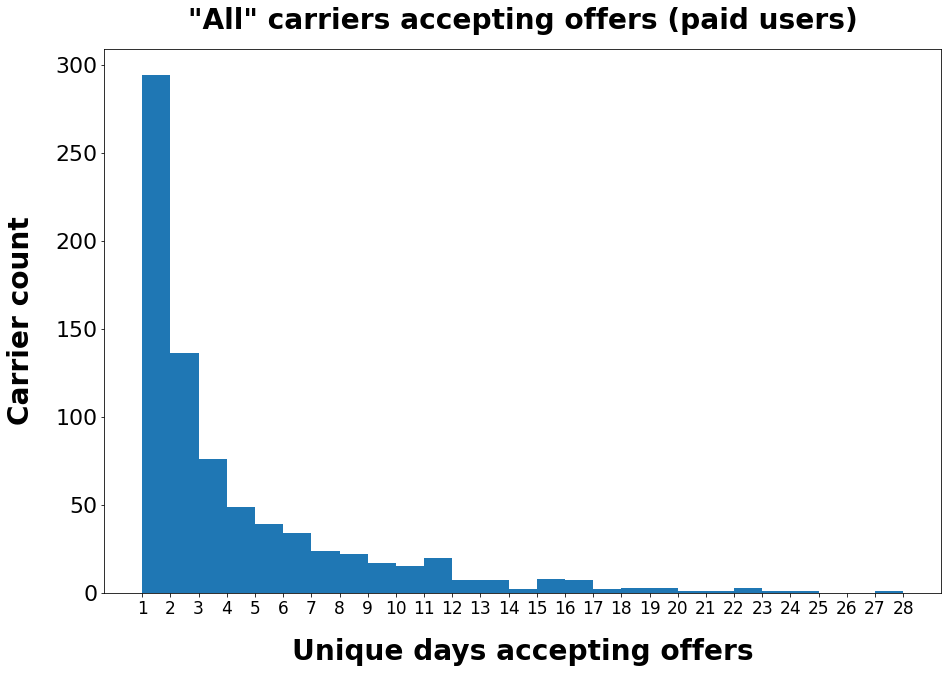

In [12]:
# histogram of unique accepted offers in last 28 days (paid and free users)
plt.figure(figsize=(15,10))
plt.hist(result_paid_users['unique_days_accepting_offers'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=22)
plt.xlabel('Unique days accepting offers', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Carrier count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('"All" carriers accepting offers (paid users)', fontsize=28, fontweight='bold', pad=20)
plt.show()

# Free users

In [13]:
result_free_users = (result.merge(braintree_with_carriers, how='left', left_on='carrier_guid',
                                           right_on='carrier_guid'))

# Free users will have a missing value under braintree_subscription_status
non_payers = result_free_users['braintree_subscription_status'].isna() == True
# dropping all paid user rows
result_free_users = result_free_users[non_payers]

result_free_users = result_free_users[['carrier_name', 'carrier_guid', 'unique_days_accepting_offers']]
result_free_users['paid_user'] = False
result_free_users

,carrier_name,carrier_guid,unique_days_accepting_offers,paid_user
0,1 CALL AWAY,d8eeb04e-1f61-4855-9d8c-9fe364dc8044,8,False
1,1 DAY AUTO TRANSPORT LLC,e7099505-fd84-4b33-b516-619c3dba082b,1,False
4,1ST SHOT TRUCKING LLC,fe1298ef-eb41-4557-a1ef-b266e557ac84,2,False
5,2 BROTHER'S EXPRESS TRANSPORT INC,81064a2c-5c6a-49a1-9913-699978b2061c,1,False
6,2 BROTHERS ENTERPRISES LLC,e0020505-fd8c-4f9b-80cd-978a4ebd16b7,1,False
...,...,...,...,...
2975,eco transport,17e62317-e67d-4394-97cb-fcb319d471c3,1,False
2976,mj parker,13de9609-5f96-43cd-a15e-0765a91613ad,1,False
2977,peker transportation,8a82a6e7-f15b-4b74-8f23-a09f09d8c93d,1,False
2978,ref ref,81cc99a5-083b-4346-a369-71ef0efa5e2f,2,False


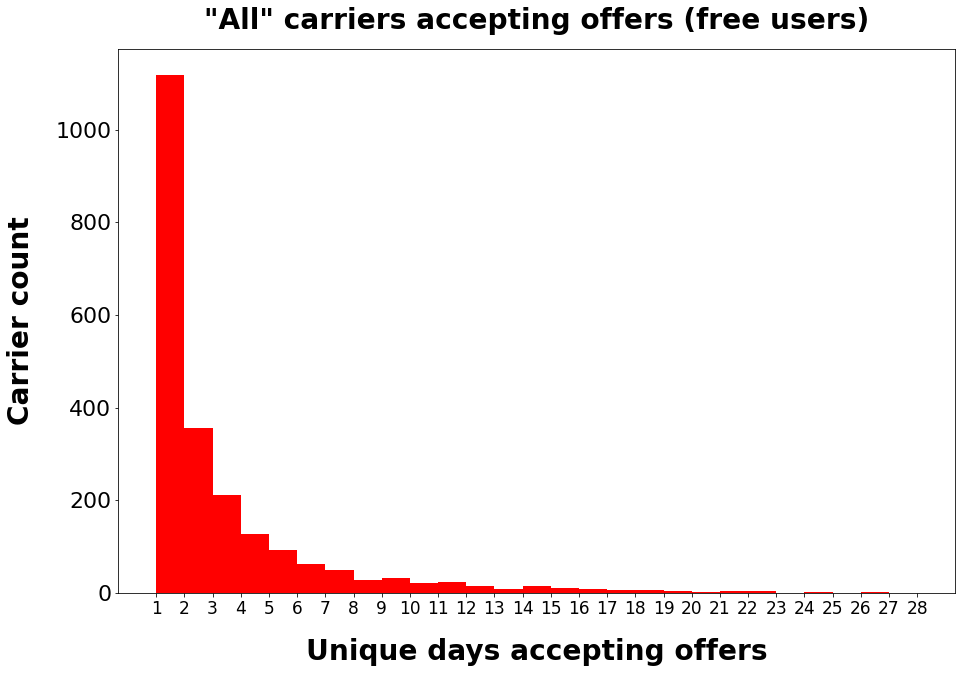

In [14]:
# histogram of unique accepted offers in last 28 days (free users)
plt.figure(figsize=(15,10))
plt.hist(result_free_users['unique_days_accepting_offers'], bins=np.arange(1, 29), color='red')
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=22)
plt.xlabel('Unique days accepting offers', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Carrier count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('"All" carriers accepting offers (free users)', fontsize=28, fontweight='bold', pad=20)
plt.show()

In [15]:
total_paid_carriers_for_days_active = []

for i in range(1,29):
    paid_active_carrier_count = (result_paid_users[result_paid_users['unique_days_accepting_offers'] >= i]
                           .groupby('unique_days_accepting_offers').count()['carrier_guid'].sum())
    
    total_paid_carriers_for_days_active.append(paid_active_carrier_count)
    


total_free_carriers_for_days_active = []

for i in range(1,29):
    free_active_carrier_count = (result_free_users[result_free_users['unique_days_accepting_offers'] >= i]
                           .groupby('unique_days_accepting_offers').count()['carrier_guid'].sum())
    
    total_free_carriers_for_days_active.append(free_active_carrier_count)

In [16]:
paid_active_carriers = pd.DataFrame()
paid_active_carriers['definition_is_this_many_days_active'] = np.arange(1,29)
paid_active_carriers.set_index('definition_is_this_many_days_active', inplace=True)
paid_active_carriers['total_carriers_at_least_this_active'] = total_paid_carriers_for_days_active
paid_active_carriers['total_percentage_active'] = round(100*paid_active_carriers['total_carriers_at_least_this_active']
                                                       /len(result_paid_users))
paid_active_carriers['total_percentage_dormant'] = 100 - paid_active_carriers['total_percentage_active']


free_active_carriers = pd.DataFrame()
free_active_carriers['definition_is_this_many_days_active'] = np.arange(1,29)
free_active_carriers.set_index('definition_is_this_many_days_active', inplace=True)
free_active_carriers['total_carriers_at_least_this_active'] = total_free_carriers_for_days_active
free_active_carriers['total_percentage_active'] = round(100*free_active_carriers['total_carriers_at_least_this_active']
                                                       /len(result_free_users))
free_active_carriers['total_percentage_dormant'] = 100 - free_active_carriers['total_percentage_active']

In [17]:
def paid_vs_non_paid(paid_metric_definition, non_paid_metric_definition):
    plt.figure(figsize=(13,11))
    plt.subplots_adjust(wspace=.9)
    
    plt.subplot(1,2,1)
    paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[paid_active_carriers.loc[paid_metric_definition, 'total_carriers_at_least_this_active'],
                           (paid_active_carriers.loc[1, 'total_carriers_at_least_this_active'] - 
                            paid_active_carriers.loc[paid_metric_definition, 'total_carriers_at_least_this_active'])],
                        palette='muted')
    for p in paid_graph.patches:
        paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        paid_graph.annotate('{}%'.format(round(100*p.get_height()/paid_active_carriers.loc[1, 'total_carriers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('Carrier Count', fontsize=28, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
accepted offer
(paid users)'''.format(paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)

        
    
    plt.subplot(1,2,2)
    non_paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[free_active_carriers.loc[non_paid_metric_definition, 'total_carriers_at_least_this_active'],
                           (free_active_carriers.loc[1, 'total_carriers_at_least_this_active'] - 
                            free_active_carriers.loc[non_paid_metric_definition, 'total_carriers_at_least_this_active'])],
                        palette='muted')
    for p in non_paid_graph.patches:
        non_paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        non_paid_graph.annotate('{}%'.format(round(100*p.get_height()/free_active_carriers.loc[1, 'total_carriers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    title = '''If {} out of 28 days
accepted offer
(free users)'''.format(non_paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

# Metric = unique days 'accepting offers' (any amount of drivers)
# Left side = Paid users
# Right side = Free users
### Our qualitative hypothesis was that a carrier would accept offers 4 out of 28 days.

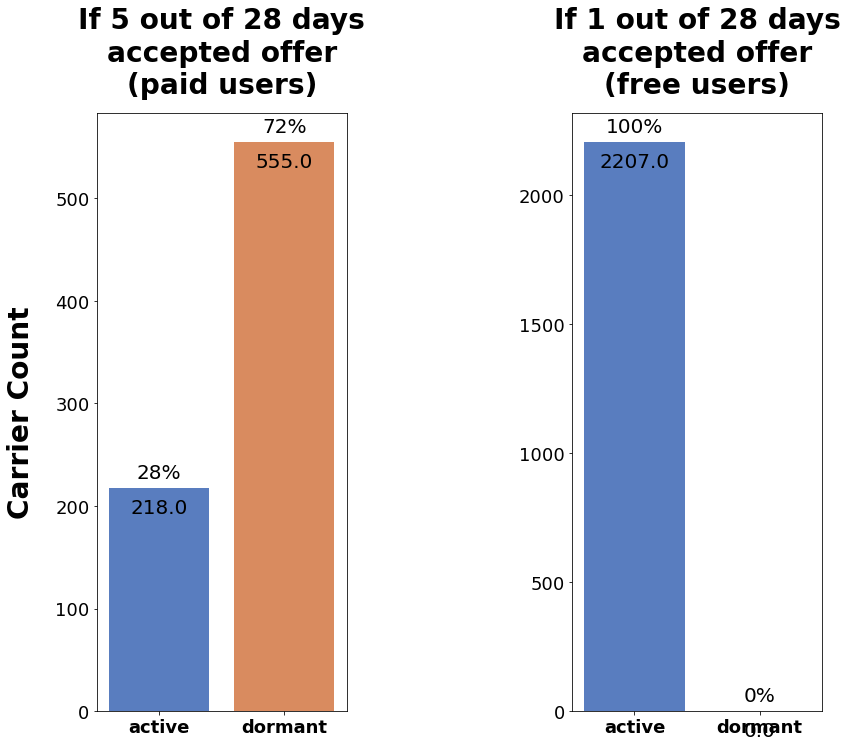

In [18]:
paid_vs_non_paid(5, 1)

In [19]:
all_paid_carriers = braintree_with_carriers
all_paid_carriers

,carrier_id,last_sub,braintree_subscription_status,name,carrier_guid
0,5466,2016-11-26 09:21:35.868856,Active,Rob's Auto Transport LLC,101ce8ba-b529-43c1-80bf-c0f6939ba2a3
1,3298,2016-11-26 09:21:30.983747,Active,Rhoades Logistics LLC,7196d66a-cd25-4ae4-bcdb-15f01b895c2e
2,4925,2017-01-20 15:19:46.097090,Active,Double Time Transport,533c4db9-1f0e-4da2-83e1-ed1385508496
3,1421,2017-05-18 13:42:02.182933,Active,"L&N Transport, LLC",4ba23995-f6ad-4efa-86f8-e3d14d4d9e32
4,433,2017-06-19 19:32:44.584252,Active,FRANK MESSINA,525f3fe2-61bf-452b-b5dd-2ff269a05231
...,...,...,...,...,...
2866,26442,2021-01-18 18:44:02.175590,Active,TRINITY DRIVE-AWAY LLC,782d3b6f-6ce2-47e2-984b-9eefb50096c9
2867,40915,2021-01-18 20:07:54.276443,Active,2517 INC,2d596f76-0137-4a06-b14b-556bad55f2e4
2868,7241,2021-01-18 20:40:43.572320,Active,DBN Trans Inc.,b81b0e8c-b9ec-4d73-85b8-ea3d10d7e962
2869,41228,2021-01-18 21:40:39.026505,Active,UNIQUE TOWING & RECOVERY,e7f98c54-f6d2-40dc-9d48-d0710a80869e


In [20]:
all_free_carriers =  carriers.merge(braintree_with_carriers, how='left',
                                        left_on='carrier_guid', right_on='carrier_guid')

# getting all free users
non_payers = all_free_carriers['braintree_subscription_status'].isna() == True
# #dropping all rows with paid users
all_free_carriers = all_free_carriers[non_payers]
all_free_carriers

,name_x,carrier_id_x,carrier_guid,carrier_id_y,last_sub,braintree_subscription_status,name_y
0,ayman,7,71918a40-f1df-4b52-b925-129ed39183f1,NaN,NaT,NaN,NaN
1,CN2,16,c623837b-04ee-4cf7-a44c-bca993c4d057,NaN,NaT,NaN,NaN
2,Transcontinental Express LLC,25,e835ef60-4200-4863-916a-0eed5bd18f93,NaN,NaT,NaN,NaN
3,Sifuentes Auto Transport,29,0a142cbc-cc41-42be-96cc-9bee4dde0929,NaN,NaT,NaN,NaN
4,A1 USA Express,37,e97661bf-33fa-4b77-b4b4-23c960e54da8,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...
40880,ACTION TRANSPORT SERVICE LLC,26082,427a843f-083d-45be-9c57-04cdcad14ce8,NaN,NaT,NaN,NaN
40882,TRANSPORTING INVOICE,1861,ee44f70f-3ca3-44a9-98b0-8e2281994b28,NaN,NaT,NaN,NaN
40884,ALL AMERICAN RV SERVICES LLC,32349,cccd264d-7453-4fbc-b76f-2074c73d5134,NaN,NaT,NaN,NaN
40885,Vip Auto Trans Inc,18659,1e03a89b-27e6-4504-ad18-46aab277840d,NaN,NaT,NaN,NaN


In [21]:
paid_active_carriers = pd.DataFrame()
paid_active_carriers['definition_is_this_many_days_active'] = np.arange(1,29)
paid_active_carriers.set_index('definition_is_this_many_days_active', inplace=True)
paid_active_carriers['total_carriers_at_least_this_active'] = total_paid_carriers_for_days_active
paid_active_carriers['total_dormant_carriers'] = ([len(all_paid_carriers) - total_paid_carriers_for_days_active[x]
                                                 for x in range(len(total_paid_carriers_for_days_active))]) 
paid_active_carriers['total_percentage_active'] = round(100*paid_active_carriers['total_carriers_at_least_this_active']
                                                      /len(all_paid_carriers))
paid_active_carriers['total_percentage_dormant'] = 100 - paid_active_carriers['total_percentage_active']


free_active_carriers = pd.DataFrame()
free_active_carriers['definition_is_this_many_days_active'] = np.arange(1,29)
free_active_carriers.set_index('definition_is_this_many_days_active', inplace=True)
free_active_carriers['total_carriers_at_least_this_active'] = total_free_carriers_for_days_active
free_active_carriers['total_dormant_carriers'] = ([len(all_free_carriers) - total_free_carriers_for_days_active[x]
                                                 for x in range(len(total_free_carriers_for_days_active))])
free_active_carriers['total_percentage_active'] = round(100*free_active_carriers['total_carriers_at_least_this_active']
                                                      /len(all_free_carriers))
free_active_carriers['total_percentage_dormant'] = 100 - free_active_carriers['total_percentage_active']

In [22]:
def all_users(paid_metric_definition, free_metric_definition):
    plt.figure(figsize=(13,11))
    plt.subplots_adjust(wspace=.9)
    
    plt.subplot(1,2,1)
    paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[paid_active_carriers.loc[paid_metric_definition, 'total_carriers_at_least_this_active'],
                           paid_active_carriers.loc[paid_metric_definition, 'total_dormant_carriers']],
                        palette='muted')
    for p in paid_graph.patches:
        paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        paid_graph.annotate('{}%'.format(round(100*p.get_height()/len(all_paid_carriers))), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('Carrier Count', fontsize=28, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
accepted offers
(paid users)'''.format(paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)

        
    
    plt.subplot(1,2,2)
    non_paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[free_active_carriers.loc[free_metric_definition, 'total_carriers_at_least_this_active'], 
                           free_active_carriers.loc[free_metric_definition, 'total_dormant_carriers']],
                        palette='muted')
    for p in non_paid_graph.patches:
        non_paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        non_paid_graph.annotate('{}%'.format(round(100*p.get_height()/len(all_free_carriers))), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    title = '''If {} out of 28 days
accepted offers
(free users)'''.format(free_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

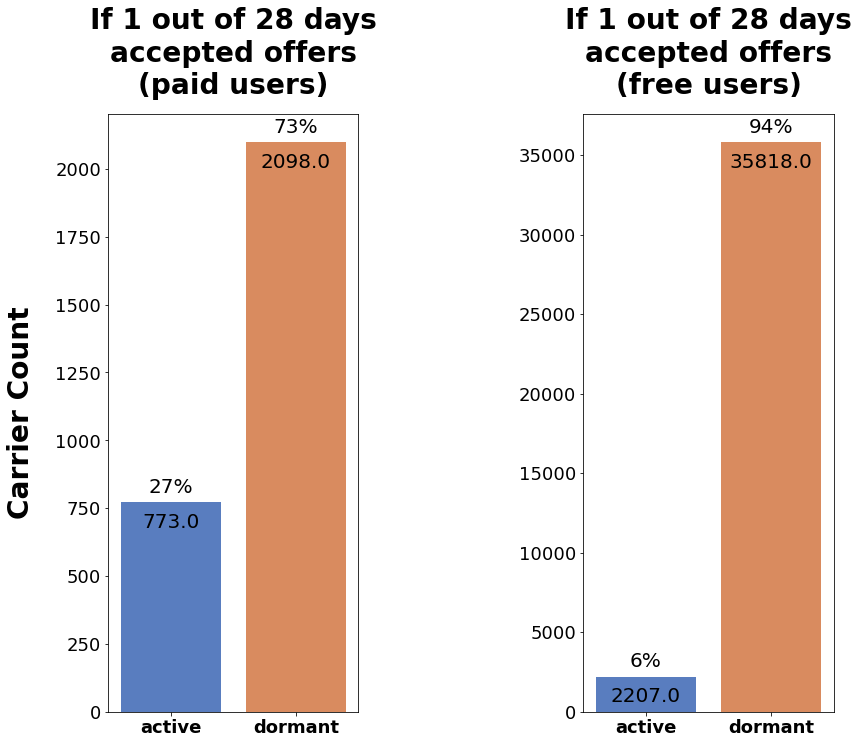

In [23]:
all_users(1, 1)